<a href="https://colab.research.google.com/github/anshupandey/Computer-Vision/blob/master/Object%20Localization/Object_Localization_greatlearning_MAY2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization

## Data Collection

In [ ]:
!wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

In [ ]:
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null; echo " done."

 done.


In [1]:
!wget -q https://raw.githubusercontent.com/anshupandey/Computer-Vision/master/Object%20Localization/PASCAL_VOC_labels.p

## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import resnet50
import cv2

In [3]:
df = pd.read_pickle("/content/PASCAL_VOC_labels.p")
df.head()

,file_name,category,cat_id,bbox
0,000012.jpg,car,6,"[96, 155, 269, 350]"
1,000017.jpg,horse,12,"[77, 89, 335, 402]"
2,000023.jpg,person,14,"[1, 2, 461, 242]"
3,000026.jpg,car,6,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,0,"[77, 103, 182, 374]"


(374, 500, 3)


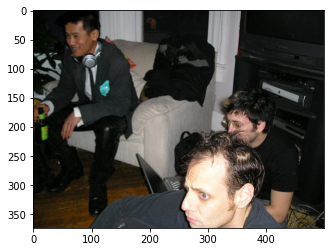

In [ ]:
main_folder = "/content/VOCdevkit/VOC2007/JPEGImages/"
img = plt.imread(main_folder + df.file_name[20])
print(img.shape)
plt.imshow(img)
plt.show()

[ 50  21 290 316]
chair


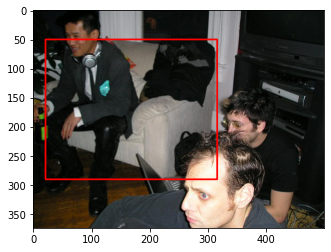

In [ ]:
bb = df.bbox[20]
print(bb)
print(df.category[20])
cv2.rectangle(img,(bb[1],bb[0]),(bb[3],bb[2]),[255,0,0],2)
plt.imshow(img)
plt.show()

In [ ]:
import imgaug
from imgaug import augmenters

In [ ]:
img = plt.imread(main_folder+df.file_name[0])
bb = df.bbox[0]
print(img.shape)
print(bb)
augobj = augmenters.Resize({"height":128,"width":128}).to_deterministic()
old_bb = imgaug.BoundingBoxesOnImage([imgaug.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2 = bb[2])],shape=img.shape)

new_img = augobj.augment_images([img])[0]
print(new_img.shape)
new_bb = augobj.augment_bounding_boxes([old_bb])[0].bounding_boxes
print(new_bb)

(333, 500, 3)
[ 96 155 269 350]
(128, 128, 3)
[BoundingBox(x1=39.6800, y1=36.9009, x2=89.6000, y2=103.3994, label=None)]


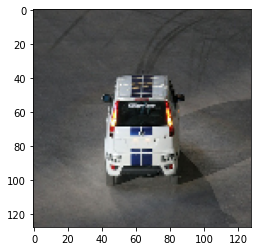

In [ ]:
plt.imshow(new_img)
plt.show()

In [ ]:
new_bb[0].x1

39.68

In [ ]:
def transform(img,bb):
  old_bb = imgaug.BoundingBoxesOnImage([imgaug.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2 = bb[2])],shape=img.shape)
  new_img = augobj.augment_images([img])[0]
  new_bb = augobj.augment_bounding_boxes([old_bb])[0].bounding_boxes[0]
  new_bb = [new_bb.x1,new_bb.y1,new_bb.x2,new_bb.y2]
  return new_img,new_bb

In [ ]:
df.head()

,file_name,category,cat_id,bbox
0,000012.jpg,car,7,"[96, 155, 269, 350]"
1,000017.jpg,horse,13,"[77, 89, 335, 402]"
2,000023.jpg,person,15,"[1, 2, 461, 242]"
3,000026.jpg,car,7,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,1,"[77, 103, 182, 374]"


In [ ]:
x = []
y1 = []
y2 = []
for i in range(df.shape[0]):
  img_path = main_folder + df.file_name[i]
  img = plt.imread(img_path)
  bb = df.bbox[i]
  img,bb = transform(img,bb)
  img = resnet50.preprocess_input(img)

  x.append(img)
  y1.append(df.cat_id[i])
  y2.append(bb)


In [ ]:
x = np.array(x)
y1 = to_categorical(y1)
y2 = np.array(y2)
print(x.shape)
print(y1.shape)
print(y2.shape)

(2501, 128, 128, 3)
(2501, 20)
(2501, 4)


In [ ]:
plt.imshow(x[0].astype('int32'))
plt.show()

## Modelling the Network

In [ ]:
from tensorflow.keras import models,layers

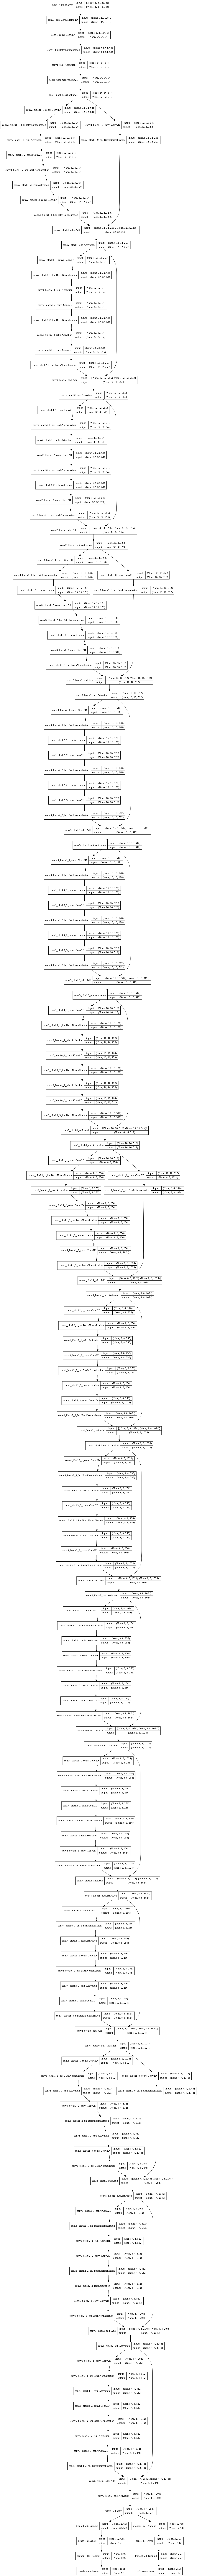

In [ ]:
input_layer = layers.Input(shape=(128,128,3))

resmodel = resnet50.ResNet50(input_tensor=input_layer,include_top=False)


for layer in resmodel.layers[:-12]:
  layer.trainable=False

current_last_layer = resmodel.output

flatten = layers.Flatten()(current_last_layer)

#classification
clf = layers.Dropout(0.5)(flatten)
clf = layers.Dense(150,activation='relu')(clf)
clf = layers.Dropout(0.5)(clf)
clf = layers.Dense(20,activation='softmax',name="classification")(clf)

#regression
reg = layers.Dropout(0.5)(flatten)
reg = layers.Dense(250,activation='relu')(reg)
reg = layers.Dropout(0.5)(reg)
reg = layers.Dense(4,activation='relu',name="regression")(reg)


model = models.Model(inputs=input_layer,outputs=[clf,reg])
plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer='adam',loss={"classification":'categorical_crossentropy','regression':'mae'},
              loss_weights={'classification':3,'regression':2},metrics={'classification':'accuracy'})

model.fit(x=x,y=[y1,y2],epochs=15,batch_size=64,validation_split=0.2,shuffle=True)

Epoch 1/15
32/32 [==============================] - 7s 129ms/step - loss: 29.6795 - classification_loss: 0.5762 - regression_loss: 13.9754 - classification_accuracy: 0.8335 - val_loss: 43.8604 - val_classification_loss: 1.7176 - val_regression_loss: 19.3539 - val_classification_accuracy: 0.5908
Epoch 2/15
32/32 [==============================] - 3s 98ms/step - loss: 30.1542 - classification_loss: 0.5188 - regression_loss: 14.2989 - classification_accuracy: 0.8443 - val_loss: 56.5897 - val_classification_loss: 2.1454 - val_regression_loss: 25.0768 - val_classification_accuracy: 0.5669
Epoch 3/15
32/32 [==============================] - 3s 98ms/step - loss: 28.4737 - classification_loss: 0.5098 - regression_loss: 13.4722 - classification_accuracy: 0.8510 - val_loss: 42.7632 - val_classification_loss: 2.3449 - val_regression_loss: 17.8642 - val_classification_accuracy: 0.5629
Epoch 4/15
32/32 [==============================] - 3s 99ms/step - loss: 29.0215 - classification_loss: 0.4613 - r

In [ ]:
!wget -q https://image.shutterstock.com/image-photo/people-beauty-lifestyle-concept-shot-260nw-662171107.jpg

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img("people-beauty-lifestyle-concept-shot-260nw-662171107.jpg",target_size=(128,128))
img = image.img_to_array(img)

img2 = img.copy()
img = resnet50.preprocess_input(img)

predictions = model.predict(img.reshape(1,128,128,3))
predictions

[array([[4.3151508e-21, 1.2433320e-18, 5.3726034e-15, 1.2516967e-20,
         2.2690694e-16, 1.1469670e-19, 1.7224610e-16, 4.9982666e-18,
         1.7412649e-10, 8.0161706e-19, 1.7800222e-15, 3.8872142e-15,
         2.3266457e-14, 8.1015803e-17, 1.0000000e+00, 4.6737495e-15,
         7.9437394e-22, 4.5993970e-14, 9.5472445e-22, 2.0804492e-19]],
       dtype=float32),
 array([[26.458334,  0.      , 73.36147 , 99.446014]], dtype=float32)]

In [ ]:
cat = np.argmax(predictions[0][0])
print(cat)
df.category[df.cat_id==cat].unique()

14


array(['person'], dtype=object)

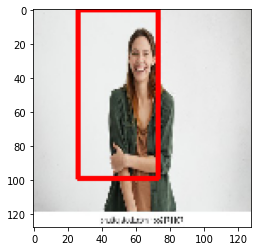

In [ ]:
bb = predictions[1][0]
cv2.rectangle(img2,(bb[0],bb[1]),(bb[2],bb[3]),[255,0,0],2)
plt.imshow(img2.astype('int32'))
plt.show()

In [ ]:
;p